In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-prediction-with-news/upload_DJIA_table.csv
/kaggle/input/stock-prediction-with-news/huffington.json


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

In [3]:
stock_df = pd.read_csv("/kaggle/input/stock-prediction-with-news/upload_DJIA_table.csv", index_col="Date").sort_index()

In [4]:
news = pd.read_csv("/kaggle/input/stock-prediction-with-news/huffington.json", sep="\t", header=None)

In [5]:
news_df = pd.DataFrame(columns=["category", "headline","short_description","date","comb"])
category=[]
headline=[]
short_description=[]
date=[]
comb = []

for i in range(news.count()[0]):
    det = json.loads(news.loc[i,0])
    category.append(det["category"])
    headline.append(det["headline"])
    short_description.append(det["short_description"])
    date.append(det["date"])
    #date.append(datetime.datetime.strptime(det["date"], "%Y-%m-%d").date())
    comb.append((". ").join([det["headline"],det["short_description"]]))
    
news_df["category"] = category
news_df["headline"] = headline
news_df["short_description"] = short_description
news_df["date"] = date
news_df["comb"] = comb


In [6]:
news_df.describe(include="all")

,category,headline,short_description,date,comb
count,200853,200853,200853,200853,200853
unique,41,199344,178353,2309,200365
top,POLITICS,Sunday Roundup,,2014-03-05,Watch The Top 9 YouTube Videos Of The Week. If...
freq,32739,90,19712,100,46


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='category', ylabel='count'>

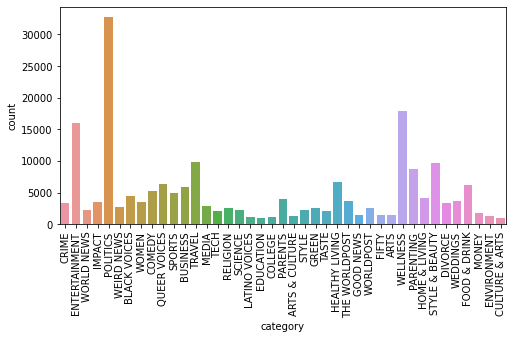

In [7]:
plt.figure(figsize=(8,4))
plt.xticks(rotation=90)
sns.countplot(news_df["category"])

In [8]:
req_categories = ["POLITICS","BUSINESS","IMPACT"]
news_df_rc = news_df[news_df.loc[:,"category"].isin(req_categories) &
                     (news_df["date"] > "2014-05-05")
                    & (news_df.headline != "")].reset_index()
news_df_rc = news_df_rc.drop(["index"], axis=1)

In [9]:
news_df_rc.describe(include="all")

,category,headline,short_description,date,comb
count,39235,39235,39235,39235,39235
unique,3,39107,34592,1480,39217
top,POLITICS,Sunday Roundup,,2014-11-05,"The Conundrum of the Midterms. The truth is, t..."
freq,32542,87,4242,97,2


In [10]:
#ob = news_df_rc["date"].value_counts().reset_index()
#plt.figure(figsize=(8,4))
#plt.plot_date(x="index", y="date", data=ob)

In [11]:
duplicated = [i for i, dup in news_df_rc["headline"].duplicated(keep=False).reset_index().iterrows() if dup.headline is True]

In [12]:
news_df_rc.loc[duplicated,["date","headline","short_description"]].sort_values(by=['headline', "date"])

,date,headline,short_description
33801,2015-01-17,10 Most Hated Companies In America,"To be truly hated, a company must alienate a l..."
33802,2015-01-17,10 Most Hated Companies In America,"To be truly hated, a company must alienate a l..."
18962,2016-08-14,8 Ways To Get People To Take You More Seriously,If you really want to be taken more seriously ...
16603,2016-10-29,8 Ways To Get People To Take You More Seriously,
3958,2017-12-04,Abortion Isn’t Main Reason More Republicans St...,Would the Democrats’ Alabama Senate candidate ...
...,...,...,...
543,2018-04-30,What A Year This Month Has Been,There was a lot of news in April 2018. See wha...
10714,2017-04-26,What Bullets Do To Bodies,The first thing Dr. Amy Goldberg told me is th...
10725,2017-04-26,What Bullets Do To Bodies,The first thing Dr. Amy Goldberg told me is th...
18626,2016-08-28,Why I March: From 1963 To Today,We knew on that bridge in Selma that we were s...


In [13]:
news_df_opt = news_df_rc.drop_duplicates(subset=["date","headline"],keep='first').reset_index()
news_df_opt = news_df_opt.drop(["index"], axis =1)

In [14]:
org = pd.Series(["3M", 'American Express', 'Amgen', 'Apple', 'Boeing', 
           'Caterpillar', 'Chevron', 'Cisco', 'Coca Cola', 'Disney', 'Dow', 'Goldman Sachs', 
       'Home Depot', 'Honeywell', 'IBM', 'Intel', 'J&J', 'JP Morgan', 'McDonald', 
       'Merck', 'Microsoft', 'Nike','UnitedHealth', 'Visa', 'Walmart',"ExxonMobil", "Pfizer","Raytheon"])
## add CEOs

org = list(org.str.lower())

In [15]:
from nltk.corpus import words
from nltk import WordNetLemmatizer
from datetime import datetime
import re
lemmatizer = WordNetLemmatizer()

In [16]:
news_df_opt["label"] = 1

In [17]:
for i, row in news_df_opt.iterrows():
    #check punctuations
    sent  = re.sub(r'[.]*|[,]*|:|[\n]*|nan|\?|"|[\*]*|[\t]*|[\r]*|&|#|!|<|>|%|[\^]*|[-]*', '', row['comb'])
    # remove numbers
    sent = re.sub(r'\d', '', sent)
    for word in sent.lower().split(' '):
        if lemmatizer.lemmatize(word) in org:
            news_df_opt["label"][i] = 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
news_df_opt[news_df_opt["label"]==2]

,category,headline,short_description,date,comb,label
74,POLITICS,"DHS Head Says She’s Still, Somehow, Unaware Of...",A publicly available 2017 assessment from the ...,2018-05-22,"DHS Head Says She’s Still, Somehow, Unaware Of...",2
992,BUSINESS,Apple Co-Founder Steve Wozniak Ditches Faceboo...,"""It's brought me more negatives than positives.""",2018-04-09,Apple Co-Founder Steve Wozniak Ditches Faceboo...,2
1205,POLITICS,White House Hires Former Disney Channel Star A...,"Caroline Sunshine starred on the show ""Shake I...",2018-03-28,White House Hires Former Disney Channel Star A...,2
1216,BUSINESS,Walmart Partners With Conservative Group To Re...,“The real world took another step toward its s...,2018-03-28,Walmart Partners With Conservative Group To Re...,2
1372,BUSINESS,Dow Plunges Amid Wall Street Fears About Trade...,The drop comes on the heels of an action by Pr...,2018-03-22,Dow Plunges Amid Wall Street Fears About Trade...,2
...,...,...,...,...,...,...
38783,BUSINESS,Why You Never See Ronald McDonald Eating McDon...,,2014-05-28,Why You Never See Ronald McDonald Eating McDon...,2
38842,BUSINESS,Pfizer Is Abandoning Controversial Plan,,2014-05-26,Pfizer Is Abandoning Controversial Plan.,2
38900,BUSINESS,Going Nowhere Fast at McDonald's,Forget the salad wraps or apple slices -- McDo...,2014-05-23,Going Nowhere Fast at McDonald's. Forget the s...,2
38945,BUSINESS,America's Tech Firms Must Not Aid Chinese Repr...,"My late great father, California Congressman T...",2014-05-21,America's Tech Firms Must Not Aid Chinese Repr...,2


In [19]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [20]:
news_df_opt['polarity'] = news_df_opt['comb'].map(lambda x: sid.polarity_scores(x))
news_df_opt['score'] = news_df_opt['polarity'].map(lambda x: x["compound"])

In [21]:
news_df_opt["final_score"] = news_df_opt["label"]*news_df_opt["score"]

In [22]:
news_df_opt.head()

,category,headline,short_description,date,comb,label,polarity,score,final_score
0,IMPACT,"With Its Way Of Life At Risk, This Remote Oyst...",The revolution is coming to rural New Brunswick.,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst...",1,"{'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...",-0.2732,-0.2732
1,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Last month a Health and Human Services officia...,2018-05-26,Trump's Crackdown On Immigrant Parents Puts Mo...,1,"{'neg': 0.07, 'neu': 0.93, 'pos': 0.0, 'compou...",-0.4019,-0.4019
2,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,The wiretaps feature conversations between Ale...,2018-05-26,'Trump's Son Should Be Concerned': FBI Obtaine...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000
3,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,"But don't count on Robert Mueller to nail him,...",2018-05-26,Edward Snowden: There's No One Trump Loves Mor...,1,"{'neg': 0.127, 'neu': 0.742, 'pos': 0.131, 'co...",0.2732,0.2732
4,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,Just a peeping minute.,2018-05-26,Booyah: Obama Photographer Hilariously Trolls ...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000


In [23]:
stock_df = stock_df[stock_df.index > "2014-05-05"]

<AxesSubplot:xlabel='Date'>

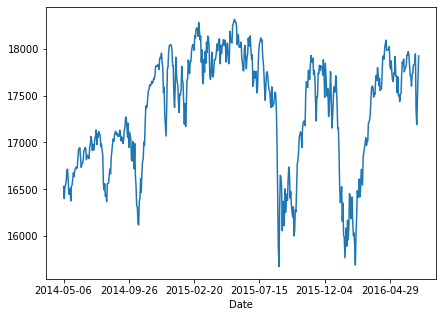

In [24]:
plt.figure(figsize=(7,5))
stock_df["Open"].plot()


<AxesSubplot:xlabel='Date'>

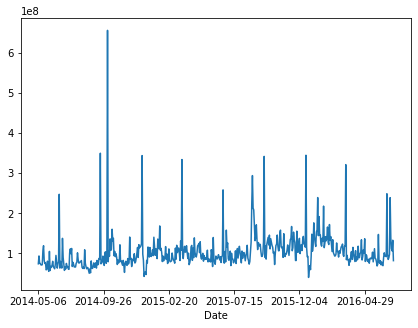

In [25]:
stock_df["Volume"].plot(figsize=(7,5))

In [26]:
len(stock_df)

545

In [27]:
stock_df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-05-06,16529.849609,16529.849609,16399.990234,16401.019531,74340000,16401.019531
2014-05-07,16401.660156,16522.939453,16357.349609,16518.539062,93870000,16518.539062
2014-05-08,16518.160156,16622.949219,16502.009766,16550.970703,75620000,16550.970703
2014-05-09,16551.230469,16588.769531,16498.710938,16583.339844,74980000,16583.339844
2014-05-12,16584.820312,16704.839844,16584.820312,16695.470703,71550000,16695.470703


In [28]:
opt = news_df_opt[["date","final_score"]].groupby("date").mean()
opt["Close"]=''
opt["Open"]=''

In [29]:
opt.head()

,final_score,Close,Open
date,,,
2014-05-06,0.047600,,
2014-05-07,0.212041,,
2014-05-08,0.024937,,
2014-05-09,0.210100,,
2014-05-10,0.058632,,


In [30]:
for i, ob in opt.iterrows():
    if i in stock_df.index:
        opt["Close"][i] = stock_df[stock_df.index == i]["Close"][0]
        opt["Open"][i] = stock_df[stock_df.index == i]["Open"][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
#removing first day's data since we are working on next day's prediction
#next_day_open.pop(0)
#next_day_open.append('')

In [32]:
df = opt[opt["Open"]!= '']

In [33]:
#df["Open"] = Open
#df = df[df["Open"]!= '']

In [34]:
df.head()

,final_score,Close,Open
date,,,
2014-05-06,0.047600,16401.019531,16529.849609
2014-05-07,0.212041,16518.539062,16401.660156
2014-05-08,0.024937,16550.970703,16518.160156
2014-05-09,0.210100,16583.339844,16551.230469
2014-05-12,-0.124447,16695.470703,16584.820312


Process testing and training data

In [35]:
train = int(0.8*len(df))
train_df = df.iloc[:train]
test_df = df.iloc[train:]

In [36]:
x_train = train_df.drop(["Open"], axis =1)
y_train = train_df["Open"]

x_test = test_df.drop(["Open"], axis =1)
y_test = test_df["Open"]

In [37]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_scaler.fit(x_train)

MinMaxScaler()

In [38]:
scaler = MinMaxScaler()

In [39]:
scaler.fit(train_df)

MinMaxScaler()

In [40]:
train = scaler.transform(train_df)
test = scaler.transform(test_df)

In [41]:
x_train = train[:,[0,1]]
y_train = train[:,2] 
x_test = test[:,[0,1]]
y_test = test[:,2] 

In [42]:
#x_train = x_scaler.transform(x_train)
#x_test = x_scaler.transform(x_test)

In [43]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [44]:
# We're only using one feature in our time series
n_features = 2
batch_size = 2

In [45]:
length = 10 #10 business days
generator = TimeseriesGenerator(x_train, y_train, length=length, batch_size=batch_size)

In [46]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(x_test,y_test, length=length, batch_size=batch_size)

In [49]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
213/213 [==============================] - 4s 11ms/step - loss: 0.0838 - val_loss: 0.0041
Epoch 2/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 3/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0093
Epoch 4/20
213/213 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 5/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 6/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/20
213/213 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 8.7400e-04
Epoch 9/20
213/213 [==============================] - 1s 6ms/step - loss: 8.0546e-04 - val_loss: 6.7221e-04
Epoch 10/20
213/213 [==============================] - 1s 6ms/step - loss: 5.9987e-04 -

<AxesSubplot:>

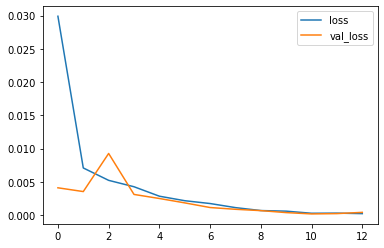

In [50]:
losses = pd.DataFrame(model.history.history)
losses.plot()

**Evaluation**

In [51]:
first_eval_batch = x_train[-length:]

In [52]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [53]:
model.predict(first_eval_batch)

array([[0.13301441]], dtype=float32)

In [54]:
y_test[0]

0.10763241736360651